# Noise Schedules Test

이 노트북은 `diffusion/noise_schedules.py`에 있는 다양한 노이즈 스케줄러들을 테스트하고 비교합니다.

## 🎯 목표
- Linear, Cosine, Quadratic, Sigmoid 스케줄러 비교
- 각 스케줄러의 Beta 값 분포 시각화
- Alpha 값들의 변화 추이 분석
- 실제 Forward Diffusion에서의 노이즈 패턴 비교
- 스케줄러별 성능 특성 분석


## 1. 환경 설정 및 라이브러리 임포트


In [1]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
import warnings
warnings.filterwarnings('ignore')

# Git repository 루트 찾기
def get_git_root():
    try:
        result = subprocess.run(['git', 'rev-parse', '--show-toplevel'], 
                              capture_output=True, text=True, check=True)
        return result.stdout.strip()
    except subprocess.CalledProcessError:
        # Git repository가 아닌 경우 현재 디렉토리 반환
        return str(Path.cwd().parent)

git_root = get_git_root()
project_root = Path(git_root)
sys.path.insert(0, str(project_root))

print(f"🔧 Git repository 루트: {git_root}")
print(f"📁 프로젝트 루트: {project_root}")

# GENESIS 유틸리티 임포트
from config import load_config_from_file
from dataloader.pmt_dataloader import make_dataloader
from diffusion.noise_schedules import (
    linear_beta_schedule,
    cosine_beta_schedule,
    quadratic_beta_schedule,
    sigmoid_beta_schedule,
    get_noise_schedule,
    compute_alpha_schedule
)
from utils.denormalization import denormalize_signal, denormalize_label
from utils.event_visualization.event_fast import plot_event_fast

# 설정
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
print("✅ 라이브러리 임포트 완료!")


🔧 Git repository 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
📁 프로젝트 루트: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS
✅ 라이브러리 임포트 완료!


## 2. 노이즈 스케줄러 생성 및 비교


In [2]:
# 테스트 파라미터
timesteps = 1000
beta_start = 1e-4
beta_end = 2e-2
cosine_s = 0.008

print(f"🎯 테스트 파라미터:")
print(f"  - Timesteps: {timesteps}")
print(f"  - Beta Start: {beta_start}")
print(f"  - Beta End: {beta_end}")
print(f"  - Cosine S: {cosine_s}")

# 각 스케줄러별 Beta 값 생성
schedules = {
    'Linear': linear_beta_schedule(timesteps, beta_start, beta_end),
    'Cosine': cosine_beta_schedule(timesteps, cosine_s),
    'Quadratic': quadratic_beta_schedule(timesteps, beta_start, beta_end),
    'Sigmoid': sigmoid_beta_schedule(timesteps, beta_start, beta_end)
}

print(f"\n✅ {len(schedules)}개의 노이즈 스케줄러 생성 완료!")

# 각 스케줄러의 기본 통계
for name, betas in schedules.items():
    print(f"\n📊 {name} 스케줄러:")
    print(f"  - Beta 범위: [{betas.min():.6f}, {betas.max():.6f}]")
    print(f"  - Beta 평균: {betas.mean():.6f}")
    print(f"  - Beta 표준편차: {betas.std():.6f}")


🎯 테스트 파라미터:
  - Timesteps: 1000
  - Beta Start: 0.0001
  - Beta End: 0.02
  - Cosine S: 0.008

✅ 4개의 노이즈 스케줄러 생성 완료!

📊 Linear 스케줄러:
  - Beta 범위: [0.000100, 0.020000]
  - Beta 평균: 0.010050
  - Beta 표준편차: 0.005753

📊 Cosine 스케줄러:
  - Beta 범위: [0.000100, 0.999900]
  - Beta 평균: 0.012443
  - Beta 표준편차: 0.051883

📊 Quadratic 스케줄러:
  - Beta 범위: [0.000100, 0.020000]
  - Beta 평균: 0.007174
  - Beta 표준편차: 0.005896

📊 Sigmoid 스케줄러:
  - Beta 범위: [0.000149, 0.019951]
  - Beta 평균: 0.010050
  - Beta 표준편차: 0.008140


## 3. Beta 스케줄 비교 시각화


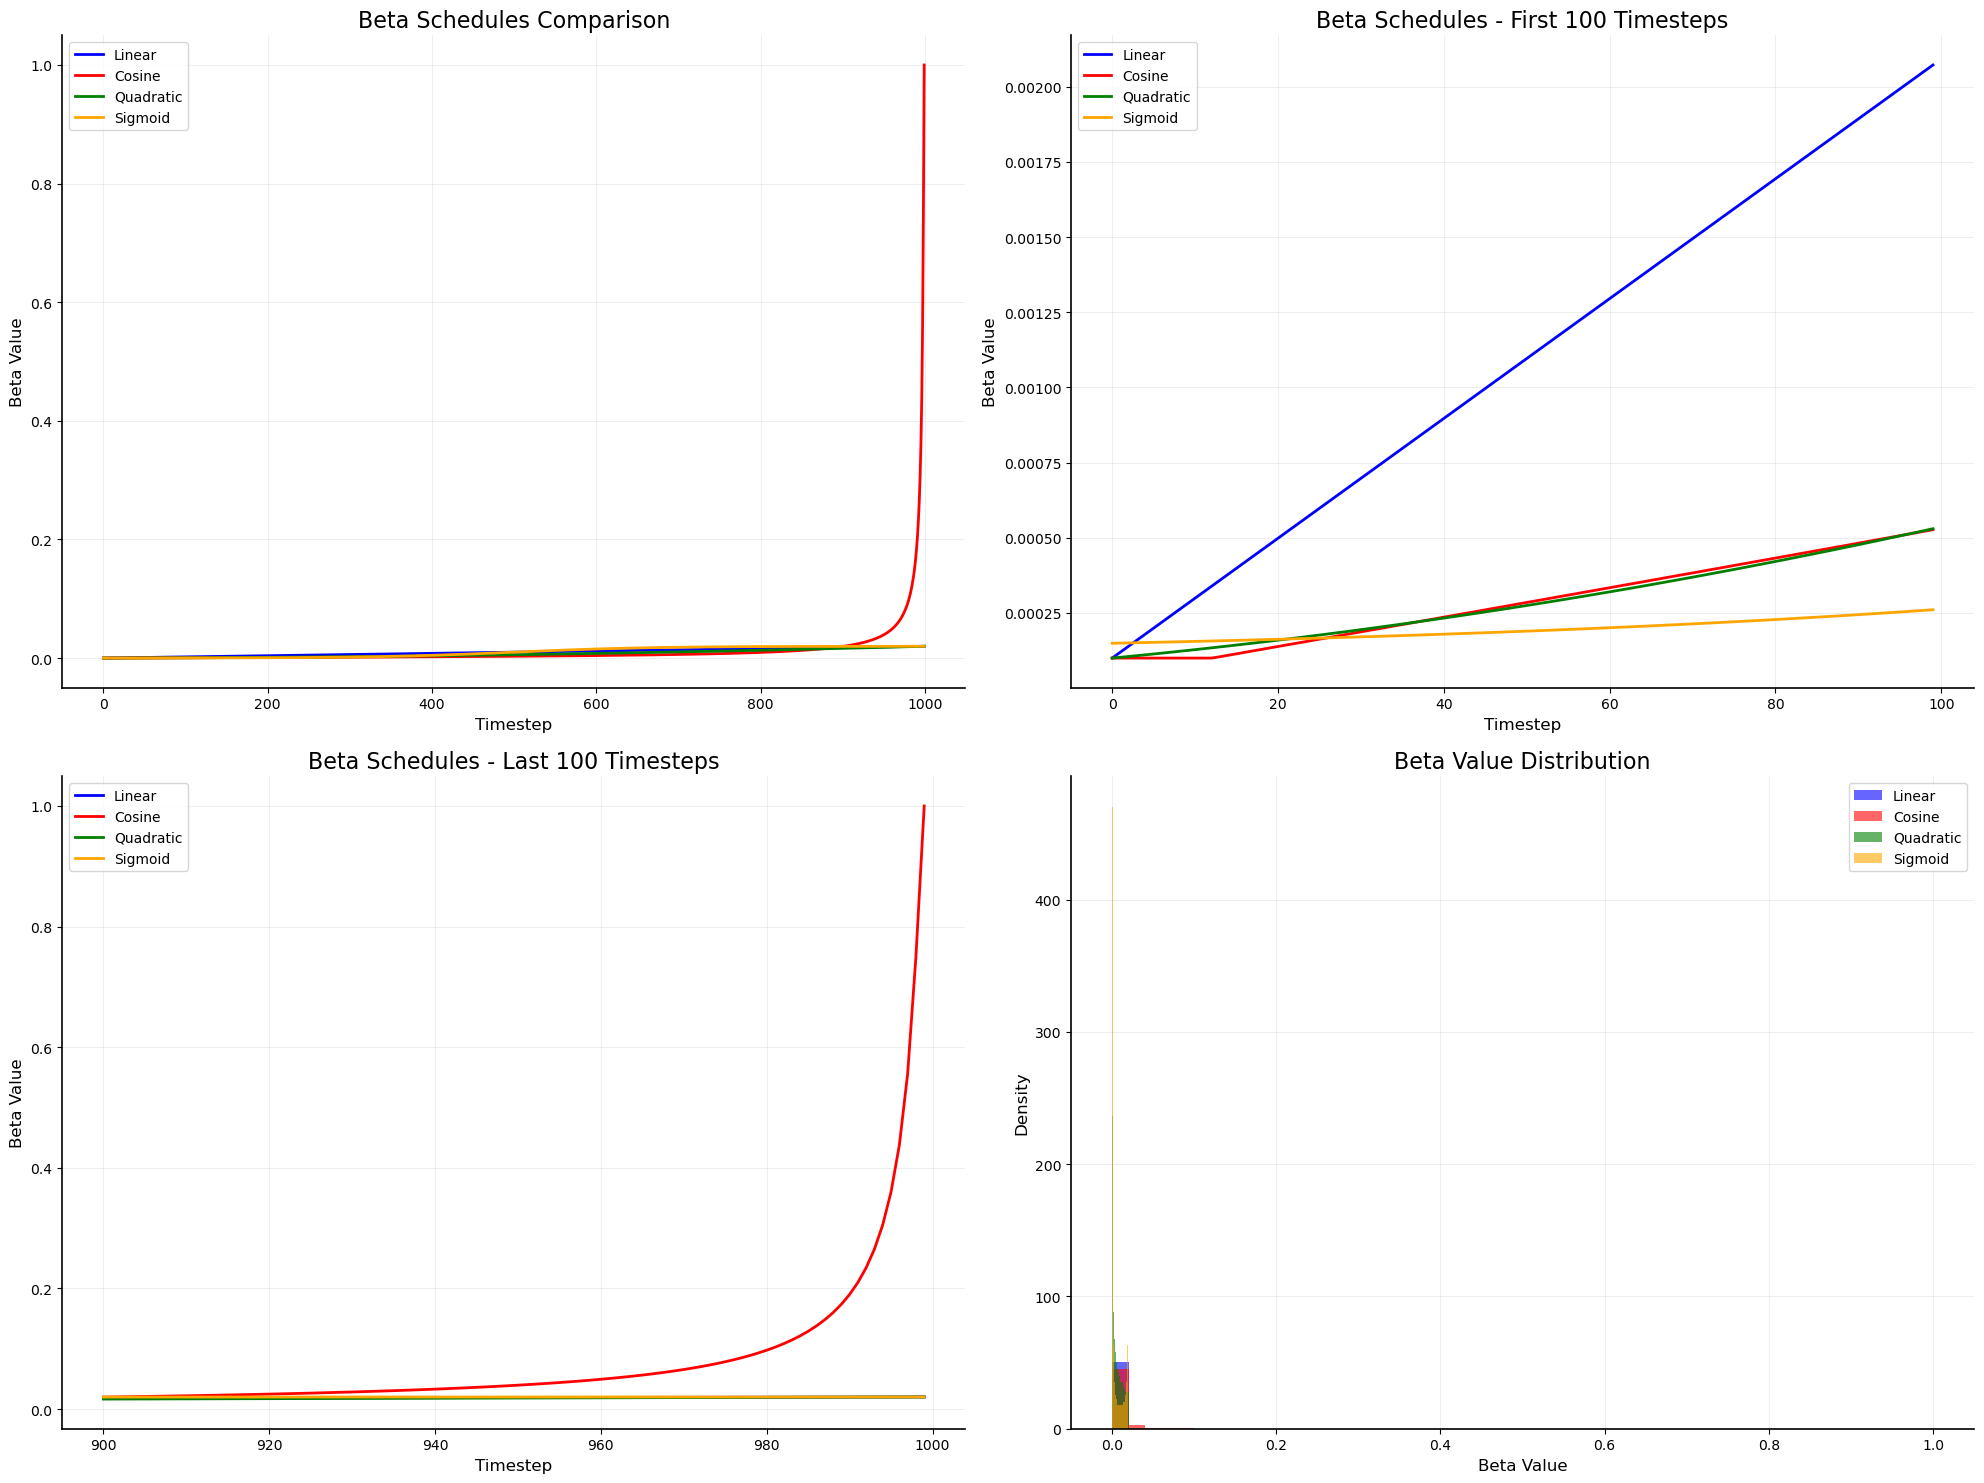

✅ Beta 스케줄 비교 시각화 완료!


In [3]:
# Beta 스케줄 시각화
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

colors = ['blue', 'red', 'green', 'orange']
timestep_range = torch.arange(timesteps)

# 전체 Beta 스케줄
ax = axes[0, 0]
for i, (name, betas) in enumerate(schedules.items()):
    ax.plot(timestep_range, betas, label=name, color=colors[i], linewidth=2)
ax.set_title('Beta Schedules Comparison', fontsize=16)
ax.set_xlabel('Timestep')
ax.set_ylabel('Beta Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 초기 100 timestep 확대
ax = axes[0, 1]
zoom_range = 100
for i, (name, betas) in enumerate(schedules.items()):
    ax.plot(timestep_range[:zoom_range], betas[:zoom_range], label=name, color=colors[i], linewidth=2)
ax.set_title(f'Beta Schedules - First {zoom_range} Timesteps', fontsize=16)
ax.set_xlabel('Timestep')
ax.set_ylabel('Beta Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 마지막 100 timestep 확대
ax = axes[1, 0]
for i, (name, betas) in enumerate(schedules.items()):
    ax.plot(timestep_range[-zoom_range:], betas[-zoom_range:], label=name, color=colors[i], linewidth=2)
ax.set_title(f'Beta Schedules - Last {zoom_range} Timesteps', fontsize=16)
ax.set_xlabel('Timestep')
ax.set_ylabel('Beta Value')
ax.legend()
ax.grid(True, alpha=0.3)

# Beta 분포 히스토그램
ax = axes[1, 1]
for i, (name, betas) in enumerate(schedules.items()):
    ax.hist(betas.numpy(), bins=50, alpha=0.6, label=name, color=colors[i], density=True)
ax.set_title('Beta Value Distribution', fontsize=16)
ax.set_xlabel('Beta Value')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(project_root / 'testing' / 'beta_schedules_comparison.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Beta 스케줄 비교 시각화 완료!")


## 4. Alpha 값 분석 및 Forward Diffusion 테스트


In [4]:
# 각 스케줄러의 Alpha 값들 계산
alpha_schedules = {}

for name, betas in schedules.items():
    alpha_schedules[name] = compute_alpha_schedule(betas)
    print(f"✅ {name} 스케줄러 Alpha 값 계산 완료")

# 데이터 로드
config = load_config_from_file(str(project_root / 'configs' / 'default.yaml'))
h5_path = str(project_root / config.data.h5_path)
print(f"\n📁 H5 파일 경로: {h5_path}")

# 데이터 로더 생성
dataloader = make_dataloader(
    h5_path,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    replace_time_inf_with=config.data.replace_time_inf_with,
    channel_first=config.data.channel_first
)

# 하나의 배치 가져오기
x_sig, geom, label, idx = next(iter(dataloader))
print(f"✅ 데이터 로드 완료!")
print(f"📐 신호 shape: {x_sig.shape}")

# 테스트할 이벤트와 timestep들
event_idx = 0
test_timesteps = [0, 100, 250, 500, 750, 999]
original_signal = x_sig[event_idx].clone()

print(f"\n🎯 이벤트 {event_idx} Forward Diffusion 테스트")
print(f"📊 테스트 timesteps: {test_timesteps}")

# Forward Diffusion 함수 정의
def apply_forward_diffusion(x, timestep, alphas_dict):
    """Apply forward diffusion using precomputed alpha values."""
    sqrt_alphas_cumprod_t = alphas_dict['sqrt_alphas_cumprod'][timestep]
    sqrt_one_minus_alphas_cumprod_t = alphas_dict['sqrt_one_minus_alphas_cumprod'][timestep]
    
    # Generate noise
    noise = torch.randn_like(x)
    
    # Forward diffusion: x_t = sqrt(ᾱ_t) * x_0 + sqrt(1-ᾱ_t) * ε
    noisy_x = sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise
    
    return noisy_x, noise

# 각 스케줄러별 Forward Diffusion 결과
scheduler_results = {}

for name, alphas in alpha_schedules.items():
    print(f"\n🔄 {name} 스케줄러 Forward Diffusion 적용 중...")
    
    results = {}
    for t in test_timesteps:
        noisy_signal, noise = apply_forward_diffusion(
            original_signal.unsqueeze(0), t, alphas
        )
        results[t] = noisy_signal.squeeze(0)
        print(f"  ✅ Timestep {t} 완료")
    
    scheduler_results[name] = results
    print(f"✅ {name} 완료!")

print(f"\n🎉 모든 스케줄러 Forward Diffusion 완료!")


✅ Linear 스케줄러 Alpha 값 계산 완료
✅ Cosine 스케줄러 Alpha 값 계산 완료
✅ Quadratic 스케줄러 Alpha 값 계산 완료
✅ Sigmoid 스케줄러 Alpha 값 계산 완료

📁 H5 파일 경로: /Users/pmj0324/Sicence/IceCube/GENESIS/GENESIS/GENESIS-data/22644_0921_time_shift.h5
✅ 데이터 로드 완료!
📐 신호 shape: torch.Size([4, 2, 5160])

🎯 이벤트 0 Forward Diffusion 테스트
📊 테스트 timesteps: [0, 100, 250, 500, 750, 999]

🔄 Linear 스케줄러 Forward Diffusion 적용 중...
  ✅ Timestep 0 완료
  ✅ Timestep 100 완료
  ✅ Timestep 250 완료
  ✅ Timestep 500 완료
  ✅ Timestep 750 완료
  ✅ Timestep 999 완료
✅ Linear 완료!

🔄 Cosine 스케줄러 Forward Diffusion 적용 중...
  ✅ Timestep 0 완료
  ✅ Timestep 100 완료
  ✅ Timestep 250 완료
  ✅ Timestep 500 완료
  ✅ Timestep 750 완료
  ✅ Timestep 999 완료
✅ Cosine 완료!

🔄 Quadratic 스케줄러 Forward Diffusion 적용 중...
  ✅ Timestep 0 완료
  ✅ Timestep 100 완료
  ✅ Timestep 250 완료
  ✅ Timestep 500 완료
  ✅ Timestep 750 완료
  ✅ Timestep 999 완료
✅ Quadratic 완료!

🔄 Sigmoid 스케줄러 Forward Diffusion 적용 중...
  ✅ Timestep 0 완료
  ✅ Timestep 100 완료
  ✅ Timestep 250 완료
  ✅ Timestep 500 완료
  ✅ Timestep 750 

## 5. 스케줄러별 노이즈 패턴 비교 및 결과 요약


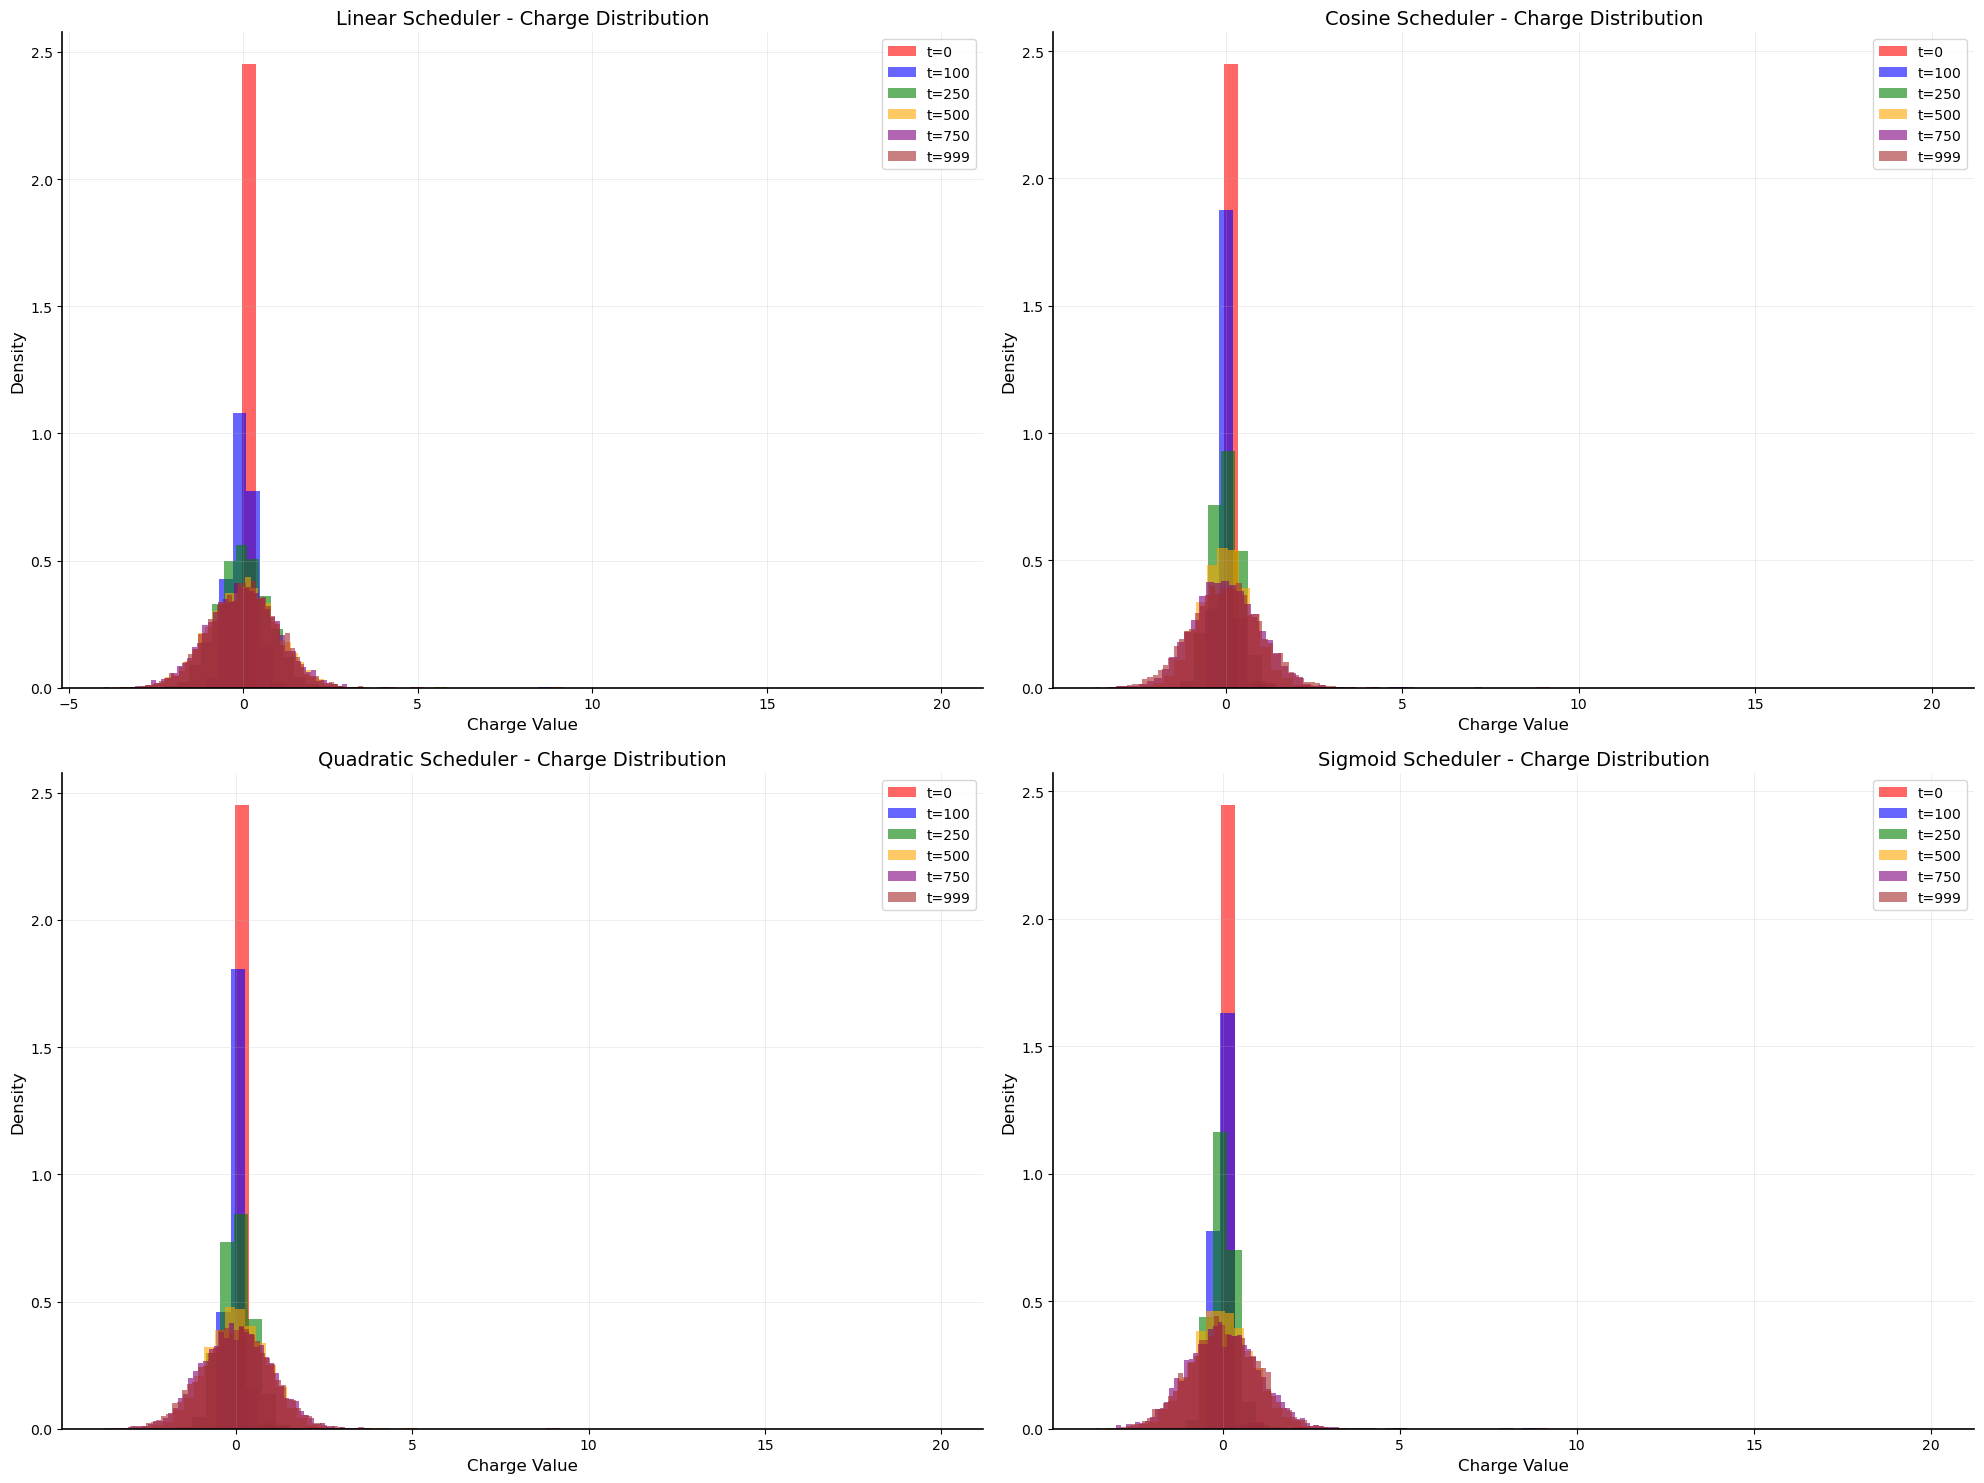

✅ 스케줄러별 Charge 분포 비교 완료!

📊 NOISE SCHEDULE CHARACTERISTICS ANALYSIS

🔸 LINEAR SCHEDULE:
  📈 Beta Statistics:
    - Range: [0.000100, 0.020000]
    - Mean: 0.010050
    - Std: 0.005753
    - Start/End ratio: 0.005
  🔊 Final Noise Std: 1.0000
  📡 Final Signal Coefficient: 0.0064

🔸 COSINE SCHEDULE:
  📈 Beta Statistics:
    - Range: [0.000100, 0.999900]
    - Mean: 0.012443
    - Std: 0.051883
    - Start/End ratio: 0.000
  🔊 Final Noise Std: 1.0000
  📡 Final Signal Coefficient: 0.0000

🔸 QUADRATIC SCHEDULE:
  📈 Beta Statistics:
    - Range: [0.000100, 0.020000]
    - Mean: 0.007174
    - Std: 0.005896
    - Start/End ratio: 0.005
  🔊 Final Noise Std: 0.9996
  📡 Final Signal Coefficient: 0.0271

🔸 SIGMOID SCHEDULE:
  📈 Beta Statistics:
    - Range: [0.000149, 0.019951]
    - Mean: 0.010050
    - Std: 0.008140
    - Start/End ratio: 0.007
  🔊 Final Noise Std: 1.0000
  📡 Final Signal Coefficient: 0.0063


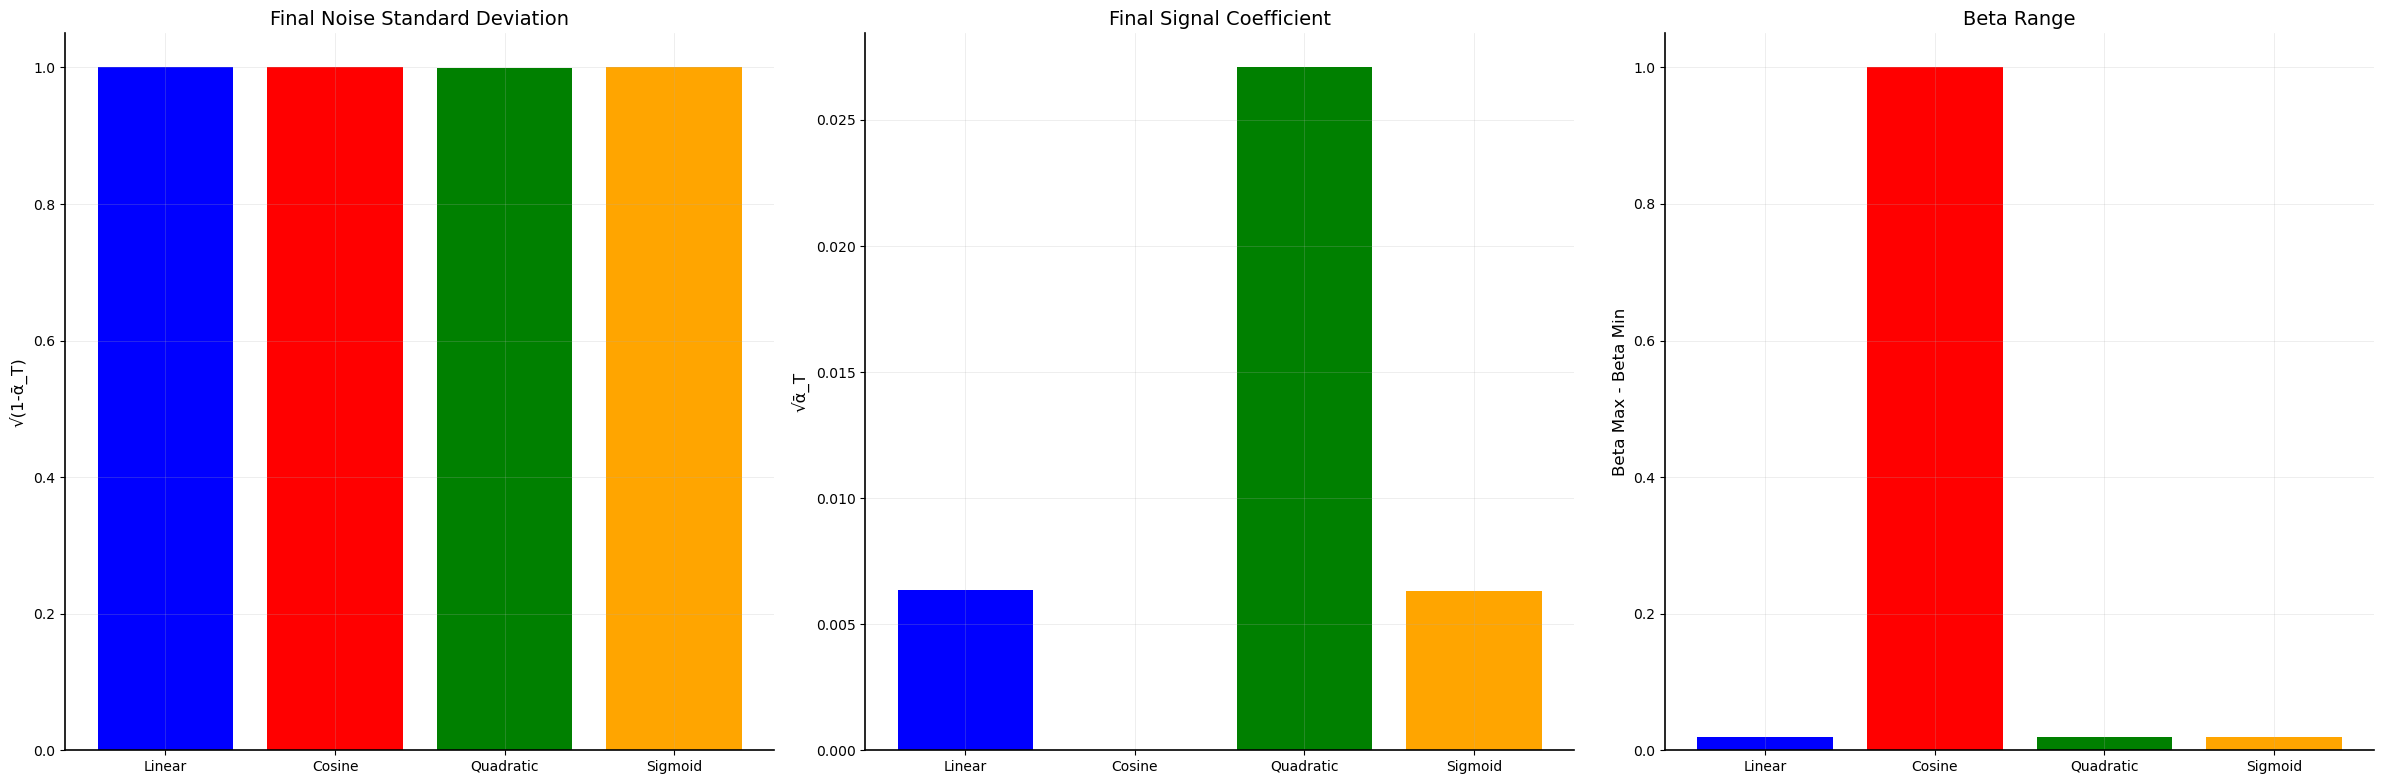


✅ 모든 분석 완료! 결과 이미지들이 testing/ 폴더에 저장되었습니다.
📁 저장된 파일들:
  - beta_schedules_comparison.png
  - noise_schedule_charge_comparison.png
  - noise_schedule_characteristics.png


In [5]:
# 스케줄러별 노이즈 패턴 시각화
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

colors_timestep = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i, (scheduler_name, results) in enumerate(scheduler_results.items()):
    ax = axes[i]
    
    # Charge 채널 시각화 (첫 번째 채널)
    for j, (t, noisy_signal) in enumerate(results.items()):
        charge_data = noisy_signal[0].cpu().numpy()
        
        # 히스토그램
        ax.hist(charge_data, bins=50, alpha=0.6, 
               label=f't={t}', color=colors_timestep[j % len(colors_timestep)], density=True)
    
    ax.set_title(f'{scheduler_name} Scheduler - Charge Distribution', fontsize=14)
    ax.set_xlabel('Charge Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(project_root / 'testing' / 'noise_schedule_charge_comparison.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ 스케줄러별 Charge 분포 비교 완료!")

# 각 스케줄러의 특성 분석 및 결과 요약
print("\n" + "="*80)
print("📊 NOISE SCHEDULE CHARACTERISTICS ANALYSIS")
print("="*80)

for name, betas in schedules.items():
    alphas = alpha_schedules[name]
    
    print(f"\n🔸 {name.upper()} SCHEDULE:")
    print(f"  📈 Beta Statistics:")
    print(f"    - Range: [{betas.min():.6f}, {betas.max():.6f}]")
    print(f"    - Mean: {betas.mean():.6f}")
    print(f"    - Std: {betas.std():.6f}")
    print(f"    - Start/End ratio: {betas[0]/betas[-1]:.3f}")
    
    # 노이즈 강도 분석 (마지막 timestep에서)
    final_noise_std = alphas['sqrt_one_minus_alphas_cumprod'][-1]
    print(f"  🔊 Final Noise Std: {final_noise_std:.4f}")
    
    # 신호 보존도 분석 (마지막 timestep에서)
    final_signal_coeff = alphas['sqrt_alphas_cumprod'][-1]
    print(f"  📡 Final Signal Coefficient: {final_signal_coeff:.4f}")

# 스케줄러별 특성 비교 차트
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

scheduler_names = list(schedules.keys())

# Final Noise Std 비교
final_noise_stds = [alpha_schedules[name]['sqrt_one_minus_alphas_cumprod'][-1].item() 
                   for name in scheduler_names]
axes[0].bar(scheduler_names, final_noise_stds, color=colors)
axes[0].set_title('Final Noise Standard Deviation', fontsize=14)
axes[0].set_ylabel('√(1-ᾱ_T)')
axes[0].grid(True, alpha=0.3)

# Final Signal Coefficient 비교
final_signal_coeffs = [alpha_schedules[name]['sqrt_alphas_cumprod'][-1].item() 
                      for name in scheduler_names]
axes[1].bar(scheduler_names, final_signal_coeffs, color=colors)
axes[1].set_title('Final Signal Coefficient', fontsize=14)
axes[1].set_ylabel('√ᾱ_T')
axes[1].grid(True, alpha=0.3)

# Beta Range 비교
beta_ranges = [(schedules[name].max() - schedules[name].min()).item() 
              for name in scheduler_names]
axes[2].bar(scheduler_names, beta_ranges, color=colors)
axes[2].set_title('Beta Range', fontsize=14)
axes[2].set_ylabel('Beta Max - Beta Min')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(project_root / 'testing' / 'noise_schedule_characteristics.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("✅ 모든 분석 완료! 결과 이미지들이 testing/ 폴더에 저장되었습니다.")
print("📁 저장된 파일들:")
print("  - beta_schedules_comparison.png")
print("  - noise_schedule_charge_comparison.png")
print("  - noise_schedule_characteristics.png")
print("="*80)
